In [12]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates

In [13]:
# load data
data_path = Path('../database/i10-broadway')
X_tensor = np.load(data_path / 'X_tensor_1h.npz', allow_pickle=True)['X_tensor']
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')

# Peek shapes/types to guide later steps
print('X_tensor type:', type(X_tensor), 'shape:', getattr(X_tensor, 'shape', None))
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_tensor type: <class 'numpy.ndarray'> shape: (183, 2458, 9)
X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (449814, 9)


In [14]:
X_full.head()

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04099 2025-06-13 00:00:00+00:00  68.733333            12.874167   
          2025-06-13 01:00:00+00:00  66.300000            13.379167   
          2025-06-13 02:00:00+00:00  69.050000            12.840833   
          2025-06-13 03:00:00+00:00  69.916667            12.667167   
          2025-06-13 04:00:00+00:00  70.483333            12.560833   

                                     evt_duration  evt_cat_major  \
tmc_code  time_bin                                                 
115+04099 2025-06-13 00:00:00+00:00           0.0            0.0   
          2025-06-13 01:00:00+00:00           0.0            0.0   
          2025-06-13 02:00:00+00:00           0.0            0.0   
          2025-06-13 03:00:00+00:00           0.0            0.0   
          2025-06-13 04:00:00+00:00           0.0            0.0   

                                     evt_cat_minor  evt_cat_closure  \
tmc_code  time_bin                                                    
115+04099 2025-06-13 00:00:00+00:00            0.0              0.0   
          2025-06-13 01:00:00+00:00            0.0              0.0   
          2025-06-13 02:00:00+00:00            0.0              0.0   
          2025-06-13 03:00:00+00:00            0.0              0.0   
          2025-06-13 04:00:00+00:00            0.0              0.0   

                                     evt_cat_obstruction  evt_cat_misc  miles  
tmc_code  time_bin                                                             
115+04099 2025-06-13 00:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 01:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 02:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 03:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 04:00:00+00:00                  0.0           0.0    0.5

In [15]:
# downselect to rows with any event, and balance with some no-event rows. 
# # Build any_event mask
df = X_full
events_col = ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
vals_col = ['speed', 'travel_time_seconds', 'miles']
any_event = df[events_col].fillna(0).astype(int).sum(axis=1) > 0

# Split into events and no-events
df_w_events = df[any_event]
df_wo_events = df[~any_event]

# Balance: sample no-events to match number of event rows (1:1)
n_events = len(df_w_events)
if n_events == 0:
    raise ValueError("No event rows found; cannot balance.")
neg_sample = df_wo_events.sample(n=min(n_events, len(df_wo_events)), random_state=42)
# neg_sample = df_wo_events.sample(n=1, random_state=42)

# Combine and shuffle
df_balanced = (
    pd.concat([df_w_events, neg_sample], axis=0)
      .sample(frac=1.0, random_state=42)
)
print(f"Events: {len(df_w_events)} | No-events (sampled): {len(neg_sample)} | Total balanced: {len(df_balanced)}")
print(f"Selected {len(df_balanced) / len(df) * 100}% of full data")


Events: 132 | No-events (sampled): 132 | Total balanced: 264
Selected 0.058690925582574126% of full data


In [16]:
df_w_events

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115-04200 2025-06-13 03:00:00+00:00  71.000000            15.290833   
          2025-06-13 04:00:00+00:00  60.933333            18.953500   
          2025-06-13 05:00:00+00:00  61.166667            17.874000   
          2025-06-13 06:00:00+00:00  51.650000            21.715000   
          2025-06-13 07:00:00+00:00  50.833333            21.498000   
...                                        ...                  ...   
115-04201 2025-08-01 06:00:00+00:00  31.133333            39.008333   
          2025-08-01 07:00:00+00:00  23.350000            52.684333   
          2025-08-01 08:00:00+00:00  22.616667            53.950000   
          2025-08-01 09:00:00+00:00  29.133333            40.633000   
          2025-08-01 10:00:00+00:00  28.616667            41.423333   

                                     evt_duration  evt_cat_major  \
tmc_code  time_bin                                                 
115-04200 2025-06-13 03:00:00+00:00           0.0            0.0   
          2025-06-13 04:00:00+00:00           0.0            0.0   
          2025-06-13 05:00:00+00:00           0.0            0.0   
          2025-06-13 06:00:00+00:00           0.0            0.0   
          2025-06-13 07:00:00+00:00           0.0            0.0   
...                                           ...            ...   
115-04201 2025-08-01 06:00:00+00:00           0.0            0.0   
          2025-08-01 07:00:00+00:00           0.0            0.0   
          2025-08-01 08:00:00+00:00           0.0            0.0   
          2025-08-01 09:00:00+00:00           0.0            0.0   
          2025-08-01 10:00:00+00:00           0.0            0.0   

                                     evt_cat_minor  evt_cat_closure  \
tmc_code  time_bin                                                    
115-04200 2025-06-13 03:00:00+00:00            0.0              2.0   
          2025-06-13 04:00:00+00:00            0.0              2.0   
          2025-06-13 05:00:00+00:00            0.0              2.0   
          2025-06-13 06:00:00+00:00            0.0              2.0   
          2025-06-13 07:00:00+00:00            0.0              2.0   
...                                            ...              ...   
115-04201 2025-08-01 06:00:00+00:00            0.0              1.0   
          2025-08-01 07:00:00+00:00            0.0              1.0   
          2025-08-01 08:00:00+00:00            0.0              1.0   
          2025-08-01 09:00:00+00:00            0.0              1.0   
          2025-08-01 10:00:00+00:00            0.0              1.0   

                                     evt_cat_obstruction  evt_cat_misc  miles  
tmc_code  time_bin                                                             
115-04200 2025-06-13 03:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 04:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 05:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 06:00:00+00:00                  0.0           0.0    0.5  
          2025-06-13 07:00:00+00:00                  0.0           0.0    0.5  
...                                                  ...           ...    ...  
115-04201 2025-08-01 06:00:00+00:00                  0.0           0.0    0.5  
          2025-08-01 07:00:00+00:00                  0.0           0.0    0.5  
          2025-08-01 08:00:00+00:00                  0.0           0.0    0.5  
          2025-08-01 09:00:00+00:00                  0.0           0.0    0.5  
          2025-08-01 10:00:00+00:00                  0.0           0.0    0.5  

[132 rows x 9 columns]

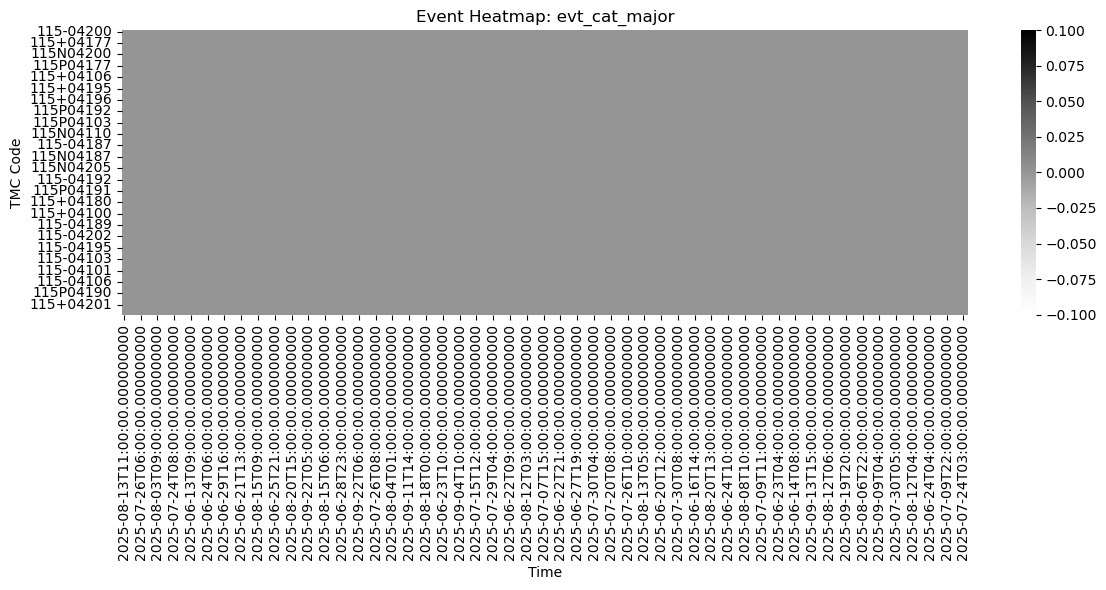

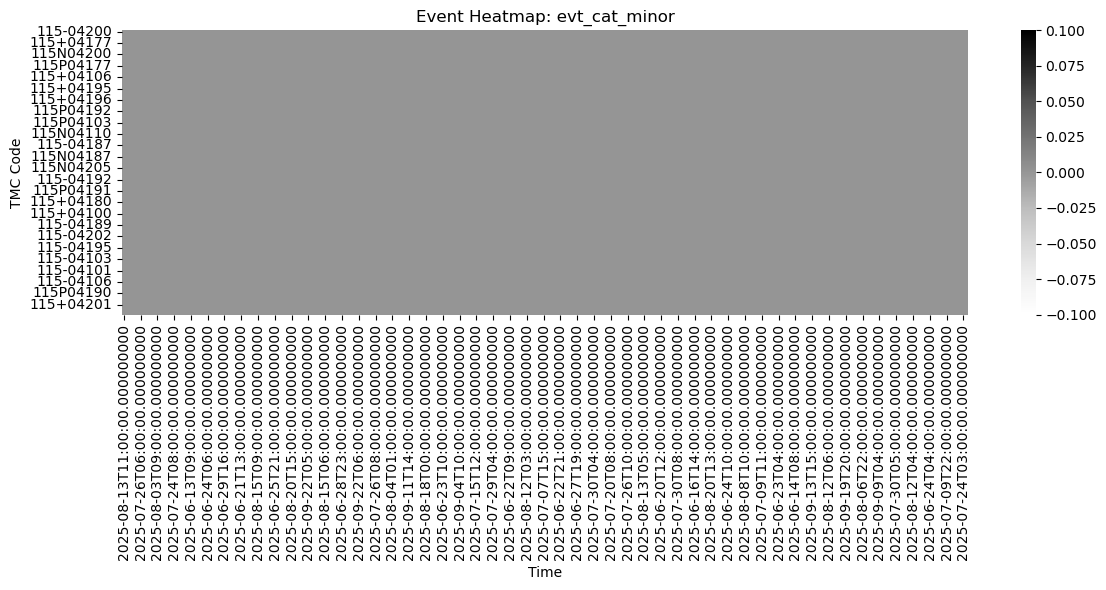

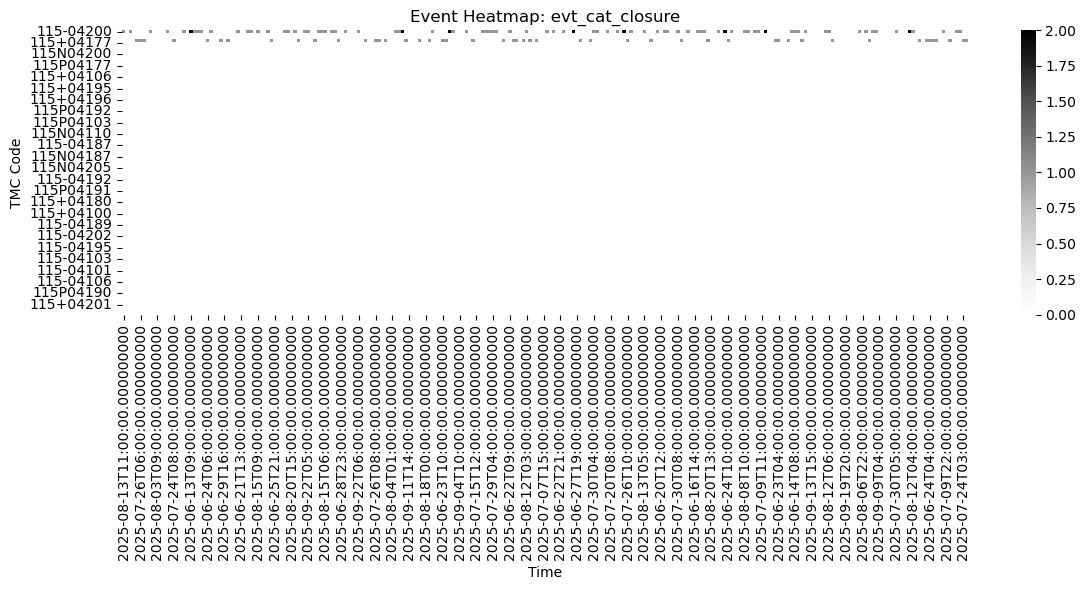

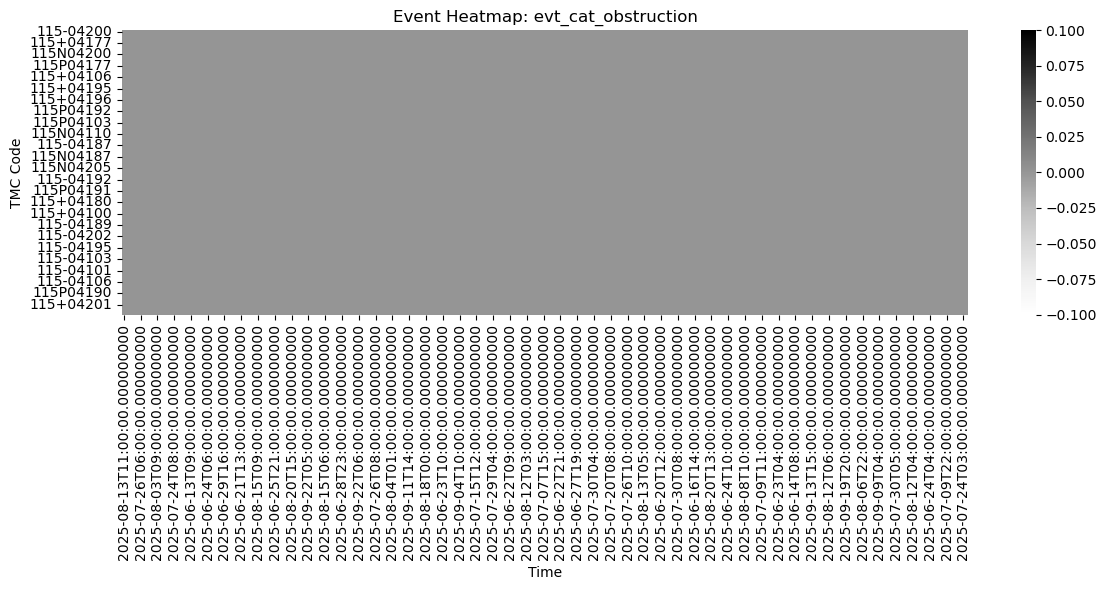

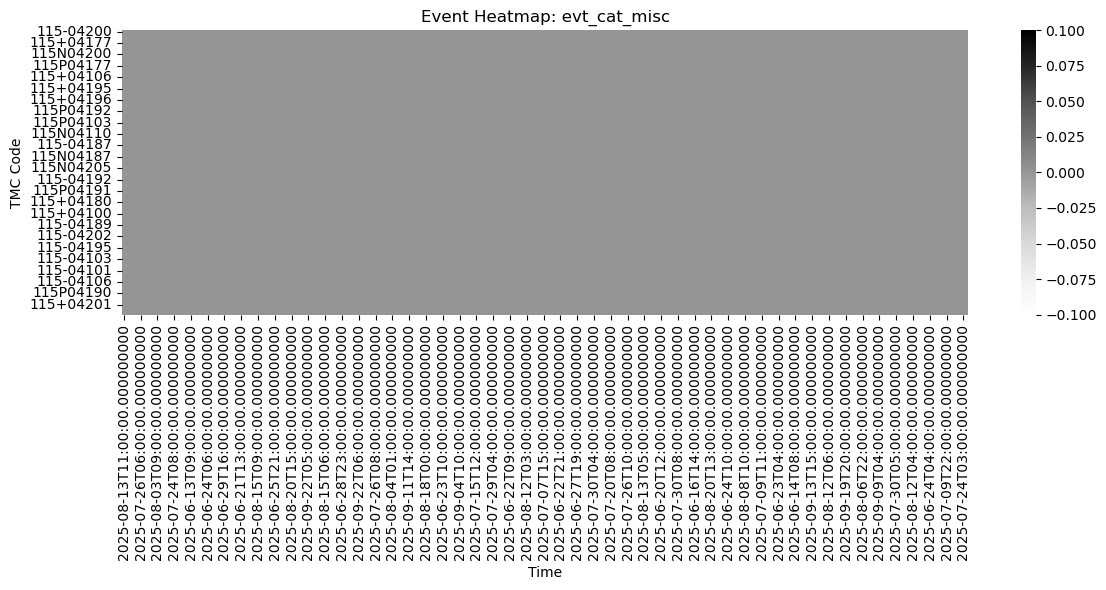

In [17]:

X_sel = df_balanced[events_col]
for col in events_col:
    data = X_sel[col].unstack(level='tmc_code').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.T, cmap='Greys')
    plt.title(f"Event Heatmap: {col}")
    plt.xlabel("Time")
    plt.ylabel("TMC Code")
    plt.tight_layout()
    plt.show()

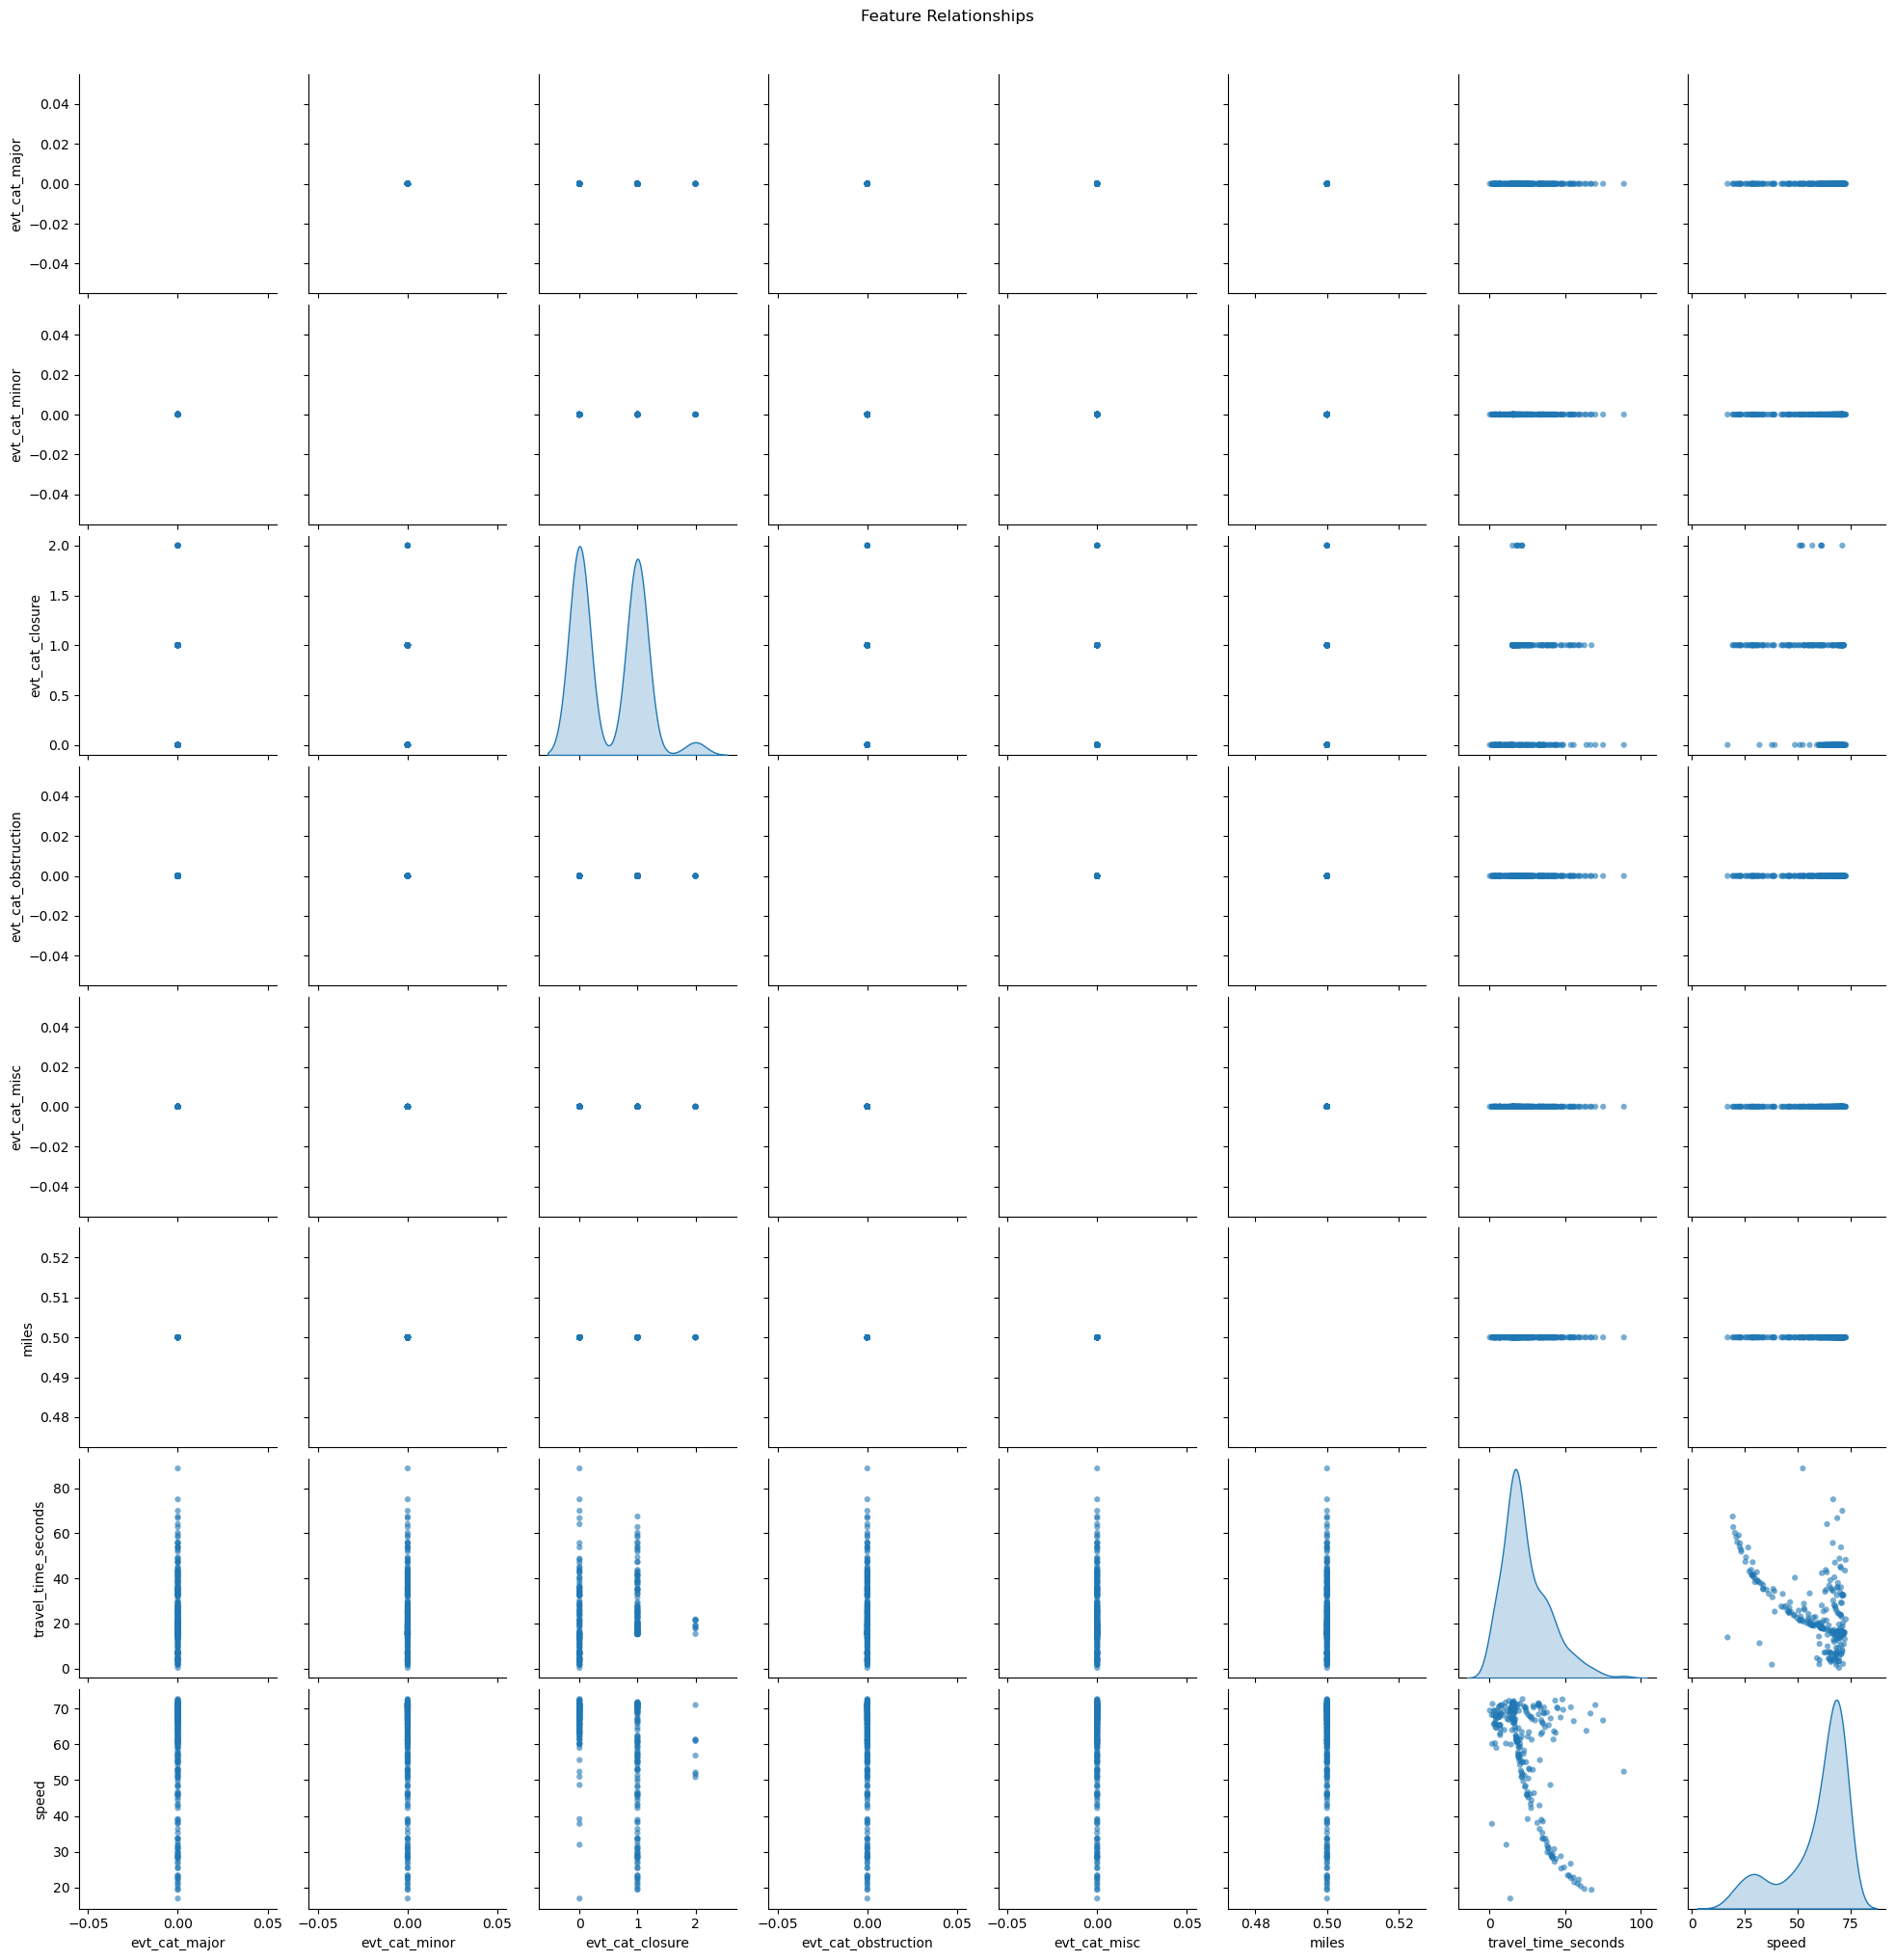

In [18]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','speed']
feature_cols = events_col + ['miles']

sample_df = df_balanced.sample(n=min(len(df_balanced), 3000), random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    # hue='any_event',
    diag_kind='kde',
    # palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [19]:
# "flatten data" into training data X and labels y, ignore the continuity in time and space. Treat data in each time bin and each TMC as independent samples.
label_col = ['travel_time_seconds']
feature_cols = events_col + ['miles']

df_flat = df_balanced.reset_index()

X = df_flat[feature_cols]#.copy()
y = df_flat[label_col]#.copy()

# Basic NA handling: drop rows with NA in y; impute X with median
mask_valid = X.notna().all(axis=1)
X = X[mask_valid]
y = y[mask_valid]

print("Features: ",feature_cols)
print('Feature shape:', X.shape, '| Label shape:', y.shape)

Features:  ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc', 'miles']
Feature shape: (264, 6) | Label shape: (264, 1)


In [20]:
# Split the data into training and test sets with shuffle (fix random seed for reproducibility)
from sklearn.model_selection import train_test_split

# If label looks discrete with few unique values, we could treat as classification; here we'll proceed as regression.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes: ', X_test.shape, y_test.shape)

Train shapes: (211, 6) (211, 1)
Test shapes:  (53, 6) (53, 1)


In [21]:
# Train a LinearRegression model with Pipeline and StandardScaler
# Report the model cross-validation error on the training set and the test set.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

models = {
    'pipe_lr_full_evt': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False is safer if any sparse-like
        ('linreg', LinearRegression())
    ]),
    'pipe_lr_no_evt': Pipeline([
        ('select', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), ['miles'])
        ], remainder='drop')),  # drop everything else
        ('linreg', LinearRegression())
    ]),
    'pipe_lr_interactions': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('linreg', LinearRegression())
    ]),
    'pipe_ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=1.0))
    ])
}

for model_name, pipe in models.items():
    print(f"\nModel: {model_name}")

    # Cross-validated negative MSE on training split
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print('CV RMSE (5-fold) mean:', cv_rmse.mean(), 'std:', cv_rmse.std())

    # Fit on training and evaluate on test
    pipe.fit(X_train, y_train)

    # Training metrics (on full training set)
    y_train_pred = pipe.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test metrics
    y_test_pred = pipe.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(' Train RMSE:', train_rmse, '| R^2:', train_r2)
    print(' Test RMSE:', test_rmse, ' | R^2:', test_r2)


Model: pipe_lr_full_evt
CV RMSE (5-fold) mean: 14.66033129520417 std: 1.5796078539164329
 Train RMSE: 14.43917902960083 | R^2: 0.014771464566971648
 Test RMSE: 17.643323696151864  | R^2: 0.007056287646424186

Model: pipe_lr_no_evt
CV RMSE (5-fold) mean: 14.59519522448528 std: 1.7892952218331641
 Train RMSE: 14.54701913918172 | R^2: 0.0
 Test RMSE: 17.767489052975076  | R^2: -0.006968624894846398

Model: pipe_lr_interactions
CV RMSE (5-fold) mean: 14.66033129520417 std: 1.5796078539164329
 Train RMSE: 14.43917902960083 | R^2: 0.014771464566971648
 Test RMSE: 17.643323696151864  | R^2: 0.007056287646424186

Model: pipe_ridge
CV RMSE (5-fold) mean: 14.659248000429391 std: 1.5809311577867025
 Train RMSE: 14.439181437993641 | R^2: 0.014771135903199784
 Test RMSE: 17.643516095196716  | R^2: 0.00703463158356632


In [22]:
corr = df_balanced[['travel_time_seconds','speed','miles',
               'evt_cat_major','evt_cat_minor','evt_cat_closure',
               'evt_cat_obstruction','evt_cat_misc']].corr()
print(corr['travel_time_seconds'])
print(corr['speed'])

travel_time_seconds    1.000000
speed                 -0.523500
miles                       NaN
evt_cat_major               NaN
evt_cat_minor               NaN
evt_cat_closure        0.121689
evt_cat_obstruction         NaN
evt_cat_misc                NaN
Name: travel_time_seconds, dtype: float64
travel_time_seconds   -0.523500
speed                  1.000000
miles                       NaN
evt_cat_major               NaN
evt_cat_minor               NaN
evt_cat_closure       -0.431373
evt_cat_obstruction         NaN
evt_cat_misc                NaN
Name: speed, dtype: float64


In [23]:
# Step 9: Compare all advanced models
results_advanced_df = pd.DataFrame(results_advanced).sort_values('Test_R2', ascending=False)

print("\n" + "="*120)
print("ADVANCED MODEL COMPARISON")
print("="*120)
print(results_advanced_df.to_string(index=False))

# Visualize comparison - enhanced version
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Test R² comparison (sorted)
ax1 = axes[0, 0]
sorted_df = results_advanced_df.sort_values('Test_R2', ascending=True)
colors_r2 = ['green' if r2 > 0.5 else 'orange' if r2 > 0.3 else 'red' for r2 in sorted_df['Test_R2']]
ax1.barh(sorted_df['Model'], sorted_df['Test_R2'], color=colors_r2, alpha=0.7)
ax1.set_xlabel('Test R²', fontsize=12)
ax1.set_title('Test Set R² (Higher is Better)', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=0.5, color='green', linestyle='--', alpha=0.3, label='Good (>0.5)')
ax1.axvline(x=0.7, color='darkgreen', linestyle='--', alpha=0.3, label='Excellent (>0.7)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: RMSE comparison (Train vs Test)
ax2 = axes[0, 1]
x = np.arange(len(results_advanced_df))
width = 0.35
ax2.bar(x - width/2, results_advanced_df['Train_RMSE'], width, label='Train RMSE', alpha=0.8, color='lightgreen')
ax2.bar(x + width/2, results_advanced_df['Test_RMSE'], width, label='Test RMSE', alpha=0.8, color='salmon')
ax2.set_ylabel('RMSE (seconds)', fontsize=12)
ax2.set_title('Train vs Test RMSE (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_advanced_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Overfitting check (R² gap)
ax3 = axes[1, 0]
colors_gap = ['green' if gap < 0.1 else 'orange' if gap < 0.2 else 'red' for gap in results_advanced_df['R2_gap']]
sorted_gap = results_advanced_df.sort_values('R2_gap', ascending=True)
ax3.barh(sorted_gap['Model'], sorted_gap['R2_gap'], color=colors_gap, alpha=0.7)
ax3.set_xlabel('R² Gap (Train - Test)', fontsize=12)
ax3.set_title('Overfitting Check (Lower is Better)', fontsize=14, fontweight='bold')
ax3.axvline(x=0.1, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<0.1)')
ax3.axvline(x=0.2, color='red', linestyle='--', alpha=0.5, label='High (>0.2)')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Plot 4: CV R² with error bars (reliability)
ax4 = axes[1, 1]
sorted_cv = results_advanced_df.sort_values('CV_R2_mean', ascending=True)
ax4.barh(sorted_cv['Model'], sorted_cv['CV_R2_mean'], 
         xerr=sorted_cv['CV_R2_std'], color='steelblue', alpha=0.7, capsize=5)
ax4.set_xlabel('Cross-Validation R² (mean ± std)', fontsize=12)
ax4.set_title('CV Performance (Reliability Check)', fontsize=14, fontweight='bold')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*120)
print("🏆 TOP 3 MODELS")
print("="*120)
for i, row in results_advanced_df.head(3).iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Test R² = {row['Test_R2']:.3f} | Test RMSE = {row['Test_RMSE']:.3f} | Test MAE = {row['Test_MAE']:.3f}")
    print(f"  CV R² = {row['CV_R2_mean']:.3f} ± {row['CV_R2_std']:.3f}")
    print(f"  Overfitting (R² gap) = {row['R2_gap']:.3f}")
    
print("\n" + "="*120)

NameError: name 'results_advanced' is not defined

In [ ]:
# Step 8: Evaluate all advanced models
print("Training advanced models with cross-validation...\n")
print("="*80)

results_advanced = []

for model_name, model in models_all.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")
    
    # 5-fold cross-validation on training set
    cv_scores = cross_val_score(model, X_train_enh, y_train_enh, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)
    cv_r2_scores = cross_val_score(model, X_train_enh, y_train_enh, cv=5, scoring='r2', n_jobs=-1)
    
    print(f"\n📊 Cross-Validation (5-fold):")
    print(f"   RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
    print(f"   R²:   {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")
    
    # Fit on full training set
    model.fit(X_train_enh, y_train_enh)
    
    # Training metrics
    y_train_pred = model.predict(X_train_enh)
    train_rmse = np.sqrt(mean_squared_error(y_train_enh, y_train_pred))
    train_mae = mean_absolute_error(y_train_enh, y_train_pred)
    train_r2 = r2_score(y_train_enh, y_train_pred)
    
    # Test metrics
    y_test_pred = model.predict(X_test_enh)
    test_rmse = np.sqrt(mean_squared_error(y_test_enh, y_test_pred))
    test_mae = mean_absolute_error(y_test_enh, y_test_pred)
    test_r2 = r2_score(y_test_enh, y_test_pred)
    
    print(f"\n📈 Training Set:")
    print(f"   RMSE: {train_rmse:.3f} | MAE: {train_mae:.3f} | R²: {train_r2:.3f}")
    
    print(f"\n🎯 Test Set:")
    print(f"   RMSE: {test_rmse:.3f} | MAE: {test_mae:.3f} | R²: {test_r2:.3f}")
    
    # Check for overfitting
    r2_gap = train_r2 - test_r2
    rmse_gap = test_rmse - train_rmse
    
    if r2_gap > 0.1 or rmse_gap > 5:
        print(f"\n⚠️  Warning: Potential overfitting detected!")
        print(f"   R² gap (train-test): {r2_gap:.3f}")
        print(f"   RMSE gap (test-train): {rmse_gap:.3f}")
    else:
        print(f"\n✅ Good generalization (minimal overfitting)")
        print(f"   R² gap: {r2_gap:.3f} | RMSE gap: {rmse_gap:.3f}")
    
    # Store results
    results_advanced.append({
        'Model': model_name,
        'CV_RMSE_mean': cv_rmse.mean(),
        'CV_RMSE_std': cv_rmse.std(),
        'CV_R2_mean': cv_r2_scores.mean(),
        'CV_R2_std': cv_r2_scores.std(),
        'Train_RMSE': train_rmse,
        'Train_MAE': train_mae,
        'Train_R2': train_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2,
        'R2_gap': r2_gap,
        'RMSE_gap': rmse_gap
    })

print(f"\n{'='*80}")
print("Training complete!")
print(f"{'='*80}")

In [ ]:
# Step 7: Add more advanced models to find best fit
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available, skipping XGBoost models")

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available, skipping LightGBM models")

# Define additional models
models_advanced = {}

# 1. K-Nearest Neighbors (good for local patterns, naturally regularized)
models_advanced['KNN (k=10)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=10, weights='distance'))
])

models_advanced['KNN (k=20)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=20, weights='distance'))
])

# 2. Support Vector Regression (good for small datasets, strong regularization)
models_advanced['SVR (RBF kernel)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale'))
])

models_advanced['SVR (Linear kernel)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear', C=10, epsilon=0.1))
])

# 3. AdaBoost (ensemble method, less prone to overfitting than single trees)
models_advanced['AdaBoost (n=50)'] = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)

# 4. Extra Trees (randomized trees, more robust than Random Forest)
models_advanced['Extra Trees (n=100)'] = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# 5. XGBoost (if available) - state-of-the-art gradient boosting
if XGBOOST_AVAILABLE:
    models_advanced['XGBoost (conservative)'] = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        random_state=42,
        n_jobs=-1
    )
    
    models_advanced['XGBoost (aggressive)'] = XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.05,
        reg_lambda=0.5,
        random_state=42,
        n_jobs=-1
    )

# 6. LightGBM (if available) - faster alternative to XGBoost
if LIGHTGBM_AVAILABLE:
    models_advanced['LightGBM (conservative)'] = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        num_leaves=15,
        min_child_samples=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )

print(f"\n🔧 Added {len(models_advanced)} advanced models")
print("Models to test:")
for i, name in enumerate(models_advanced.keys(), 1):
    print(f"  {i}. {name}")

# Combine with previous models (optional - use only advanced if you want)
# models_all = {**models_improved, **models_advanced}  # All models
models_all = models_advanced  # Only advanced models

print(f"\n📊 Total models to evaluate: {len(models_all)}")

In [ ]:
# Step 6: Feature importance analysis (for tree-based models)
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from Random Forest and Gradient Boosting
for model_name in ['Random Forest (n=100, max_depth=10)', 'Gradient Boosting (learning_rate=0.05)']:
    model = models_improved[model_name]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create dataframe of feature importances
        feat_imp_df = pd.DataFrame({
            'Feature': feature_cols_enhanced,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{model_name}:")
        print(feat_imp_df.to_string(index=False))
        
        # Plot top 10 features
        plt.figure(figsize=(10, 6))
        top_n = min(15, len(feat_imp_df))
        plt.barh(feat_imp_df['Feature'].head(top_n), feat_imp_df['Importance'].head(top_n), color='teal', alpha=0.7)
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
# Step 5: Compare model performance
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Test R² comparison
axes[0].barh(results_df['Model'], results_df['Test_R2'], color='steelblue')
axes[0].set_xlabel('Test R²', fontsize=12)
axes[0].set_title('Test Set R² (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: RMSE comparison
x = np.arange(len(results_df))
width = 0.35
axes[1].bar(x - width/2, results_df['Train_RMSE'], width, label='Train RMSE', alpha=0.8, color='lightgreen')
axes[1].bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE', alpha=0.8, color='salmon')
axes[1].set_ylabel('RMSE (seconds)', fontsize=12)
axes[1].set_title('Train vs Test RMSE (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Overfitting check (R² gap)
colors = ['green' if gap < 0.1 else 'orange' if gap < 0.2 else 'red' for gap in results_df['R2_gap']]
axes[2].barh(results_df['Model'], results_df['R2_gap'], color=colors, alpha=0.7)
axes[2].set_xlabel('R² Gap (Train - Test)', fontsize=12)
axes[2].set_title('Overfitting Check (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].axvline(x=0.1, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<0.1)')
axes[2].axvline(x=0.2, color='red', linestyle='--', alpha=0.5, label='High (>0.2)')
axes[2].legend()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Best model by Test R²:", results_df.iloc[0]['Model'])
print(f"   Test R² = {results_df.iloc[0]['Test_R2']:.3f}, Test RMSE = {results_df.iloc[0]['Test_RMSE']:.3f}")

In [ ]:
# Step 4: Train multiple models with regularization to prevent overfitting
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define models with built-in cross-validation for hyperparameter tuning
models_improved = {
    'RidgeCV (auto alpha)': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5))
    ]),
    
    'LassoCV (feature selection)': Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000))
    ]),
    
    'ElasticNetCV (L1+L2)': Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNetCV(
            alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
            l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            cv=5,
            max_iter=10000
        ))
    ]),
    
    'Random Forest (n=100, max_depth=10)': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,  # Limit depth to prevent overfitting
        min_samples_split=10,  # Require at least 10 samples to split
        min_samples_leaf=5,  # Require at least 5 samples per leaf
        random_state=42,
        n_jobs=-1
    ),
    
    'Gradient Boosting (learning_rate=0.05)': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,  # Slower learning reduces overfitting
        max_depth=5,  # Shallow trees
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,  # Use 80% of data per tree (stochastic)
        random_state=42
    ]),
}

print("Training models with cross-validation...\n")
print("="*80)

results = []

for model_name, model in models_improved.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")
    
    # 5-fold cross-validation on training set
    cv_scores = cross_val_score(model, X_train_enh, y_train_enh, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)
    cv_r2_scores = cross_val_score(model, X_train_enh, y_train_enh, cv=5, scoring='r2', n_jobs=-1)
    
    print(f"\n📊 Cross-Validation (5-fold):")
    print(f"   RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
    print(f"   R²:   {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")
    
    # Fit on full training set
    model.fit(X_train_enh, y_train_enh)
    
    # Training metrics
    y_train_pred = model.predict(X_train_enh)
    train_rmse = np.sqrt(mean_squared_error(y_train_enh, y_train_pred))
    train_mae = mean_absolute_error(y_train_enh, y_train_pred)
    train_r2 = r2_score(y_train_enh, y_train_pred)
    
    # Test metrics
    y_test_pred = model.predict(X_test_enh)
    test_rmse = np.sqrt(mean_squared_error(y_test_enh, y_test_pred))
    test_mae = mean_absolute_error(y_test_enh, y_test_pred)
    test_r2 = r2_score(y_test_enh, y_test_pred)
    
    print(f"\n📈 Training Set:")
    print(f"   RMSE: {train_rmse:.3f} | MAE: {train_mae:.3f} | R²: {train_r2:.3f}")
    
    print(f"\n🎯 Test Set:")
    print(f"   RMSE: {test_rmse:.3f} | MAE: {test_mae:.3f} | R²: {test_r2:.3f}")
    
    # Check for overfitting
    r2_gap = train_r2 - test_r2
    rmse_gap = test_rmse - train_rmse
    
    if r2_gap > 0.1 or rmse_gap > 5:
        print(f"\n⚠️  Warning: Potential overfitting detected!")
        print(f"   R² gap (train-test): {r2_gap:.3f}")
        print(f"   RMSE gap (test-train): {rmse_gap:.3f}")
    else:
        print(f"\n✅ Good generalization (minimal overfitting)")
        print(f"   R² gap: {r2_gap:.3f} | RMSE gap: {rmse_gap:.3f}")
    
    # Store results
    results.append({
        'Model': model_name,
        'CV_RMSE_mean': cv_rmse.mean(),
        'CV_RMSE_std': cv_rmse.std(),
        'CV_R2_mean': cv_r2_scores.mean(),
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'R2_gap': r2_gap,
        'RMSE_gap': rmse_gap
    })

print(f"\n{'='*80}")
print("Training complete!")
print(f"{'='*80}")

In [ ]:
# Step 3: Train/test split
from sklearn.model_selection import train_test_split

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enh, y_enh, test_size=0.2, random_state=42, shuffle=True
)

print(f'Train: {X_train_enh.shape[0]} samples | Test: {X_test_enh.shape[0]} samples')

In [ ]:
# Step 2: Prepare training data with new features
# Use stratified sampling to keep some event/no-event balance but use MORE data

feature_cols_enhanced = [
    'speed_lag1', 'travel_time_lag1', 'speed_rolling_mean',  # Lagged/rolling features (most important)
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',  # Temporal features
    'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc',  # Event features
    'miles'  # Segment length
]

label_col = 'travel_time_seconds'

# Create balanced dataset with MORE samples (10:1 ratio instead of 1:1)
any_event_enhanced = df_enhanced_clean[events_col].sum(axis=1) > 0
df_events_enh = df_enhanced_clean[any_event_enhanced]
df_no_events_enh = df_enhanced_clean[~any_event_enhanced]

n_events_enh = len(df_events_enh)
# Sample 10x more no-event rows for better coverage
n_sample_ratio = 10
neg_sample_enh = df_no_events_enh.sample(
    n=min(n_events_enh * n_sample_ratio, len(df_no_events_enh)), 
    random_state=42
)

df_train_enhanced = pd.concat([df_events_enh, neg_sample_enh], axis=0).sample(frac=1.0, random_state=42)

print(f"Enhanced training set: {len(df_train_enhanced)} samples")
print(f"  Events: {len(df_events_enh)} | No-events (sampled): {len(neg_sample_enh)}")
print(f"  Ratio no-events:events = {len(neg_sample_enh)/max(len(df_events_enh), 1):.1f}:1")

# Prepare X and y
X_enh = df_train_enhanced[feature_cols_enhanced].copy()
y_enh = df_train_enhanced[label_col].copy()

# Check for any remaining NaN and fill
X_enh = X_enh.fillna(X_enh.median())

print(f"\nFeature matrix shape: {X_enh.shape}")
print(f"Label shape: {y_enh.shape}")
print(f"\nFeature list ({len(feature_cols_enhanced)}): {feature_cols_enhanced}")

In [ ]:
# Step 1: Create better features with temporal information and lagged values
# Use MORE data (increase sampling ratio)

# Start with full dataset instead of just balanced subset
df_enhanced = X_full.copy()

# Add temporal features
df_enhanced = df_enhanced.reset_index()
df_enhanced['hour'] = df_enhanced['time_bin'].dt.hour
df_enhanced['day_of_week'] = df_enhanced['time_bin'].dt.dayofweek  # 0=Monday, 6=Sunday
df_enhanced['month'] = df_enhanced['time_bin'].dt.month
df_enhanced['is_weekend'] = (df_enhanced['day_of_week'] >= 5).astype(int)
df_enhanced['is_rush_hour'] = ((df_enhanced['hour'] >= 7) & (df_enhanced['hour'] <= 9) | 
                                (df_enhanced['hour'] >= 16) & (df_enhanced['hour'] <= 18)).astype(int)

# Sort by tmc_code and time for lagged features
df_enhanced = df_enhanced.sort_values(['tmc_code', 'time_bin'])

# Add lagged features (previous hour's speed and travel time)
df_enhanced['speed_lag1'] = df_enhanced.groupby('tmc_code')['speed'].shift(1)
df_enhanced['travel_time_lag1'] = df_enhanced.groupby('tmc_code')['travel_time_seconds'].shift(1)

# Add rolling mean (3-hour window) to capture trends
df_enhanced['speed_rolling_mean'] = df_enhanced.groupby('tmc_code')['speed'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

print(f"Enhanced dataset shape: {df_enhanced.shape}")
print(f"New features: hour, day_of_week, month, is_weekend, is_rush_hour, speed_lag1, travel_time_lag1, speed_rolling_mean")

# Drop rows with NaN in critical columns
df_enhanced_clean = df_enhanced.dropna(subset=['speed', 'travel_time_seconds', 'speed_lag1', 'travel_time_lag1'])
print(f"After dropping NaN: {df_enhanced_clean.shape}")

df_enhanced_clean.head()

## Improved Models with Better Features and Regularization

The current models show very poor performance (R² ≈ 0.01). Let's try:
1. **Add temporal features** (hour, day of week, month)
2. **Add lagged features** (previous hour's speed/travel time)
3. **Use more data** (increase no-event sampling ratio)
4. **Try better models** with regularization to prevent overfitting:
   - Ridge regression with cross-validated alpha
   - Lasso for feature selection
   - ElasticNet (combines L1 + L2 regularization)
   - Random Forest (handles non-linearity, less prone to overfitting)
   - Gradient Boosting (XGBoost or LightGBM)